In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam

In [3]:
dataset = pd.read_csv("coords.csv",index_col=False)
dataset.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,A,0.530803,0.581163,-1.472346e-06,0.413990,0.501149,-0.018073,0.355407,0.369223,-0.029657,...,-0.057639,0.605741,0.320499,-0.091212,0.588447,0.400885,-0.071050,0.594126,0.455363,-0.044118
1,A,0.503664,0.616673,-1.548741e-06,0.377512,0.536617,-0.016148,0.317852,0.408111,-0.028432,...,-0.057488,0.561715,0.359349,-0.085140,0.546541,0.440563,-0.067003,0.551058,0.498263,-0.044481
2,A,0.267808,0.670679,-8.506087e-07,0.187360,0.610215,-0.020350,0.141140,0.503103,-0.030225,...,-0.043488,0.369881,0.461587,-0.075160,0.362212,0.517269,-0.059621,0.349507,0.565708,-0.036153
3,A,0.289091,0.751779,-1.795283e-06,0.167962,0.654705,-0.030267,0.100007,0.499485,-0.048589,...,-0.059609,0.393687,0.455553,-0.107050,0.365366,0.547497,-0.087988,0.356335,0.612805,-0.058007
4,A,0.285160,0.762803,-1.769840e-06,0.161197,0.667723,-0.030836,0.094453,0.512100,-0.048447,...,-0.059550,0.388296,0.466932,-0.105277,0.361084,0.560643,-0.085365,0.352804,0.623975,-0.055310


In [4]:
dataset = dataset.sample(frac=1)
dataset.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
544,A,0.761235,0.501182,-8.562953e-07,0.658610,0.456901,-0.030290,0.580043,0.368323,-0.044648,...,-0.039038,0.828147,0.272384,-0.075885,0.824453,0.340032,-0.060200,0.818925,0.384807,-0.037907
28301,L,0.504249,0.539109,-1.206121e-07,0.403728,0.511307,-0.024695,0.323920,0.480352,-0.043604,...,-0.026544,0.510099,0.325422,-0.048290,0.497715,0.376351,-0.030515,0.501220,0.411247,-0.010667
36522,Q,0.025327,0.652010,1.509529e-06,0.059176,0.728496,-0.099155,0.138796,0.784399,-0.140557,...,0.000955,0.323063,0.572390,-0.028672,0.315457,0.608054,-0.031056,0.288952,0.622333,-0.022249
53807,X,0.677257,0.896656,-3.083799e-08,0.625531,0.847047,-0.026996,0.603508,0.779853,-0.039130,...,-0.045161,0.768227,0.738690,-0.073589,0.747754,0.775877,-0.065406,0.730394,0.807700,-0.051156
18117,H,0.308695,0.871564,1.159256e-06,0.278563,0.796059,-0.042845,0.326489,0.707279,-0.063556,...,-0.071390,0.476656,0.799582,-0.125473,0.417410,0.810941,-0.122791,0.369383,0.825952,-0.106864


In [5]:
data = dataset.copy(deep = True)

In [6]:
# One-hot encode the class labels
encoder = OneHotEncoder(sparse=False)
class_labels = dataset['class'].values.reshape(-1, 1)
class_labels_encoded = encoder.fit_transform(class_labels)

# Dropping the 'class' column from the dataset
features = dataset.drop('class', axis=1)

# Standardize the feature columns
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/Users/pauljohnmaddala/anaconda3/envs/tfenv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# Since we don't have a time series, we will treat each coordinate set (x, y, z) as one time step.
# This means we have 21 time steps with 3 features each.
features_reshaped = features_scaled.reshape((features_scaled.shape[0], 21, 3))

#features = features.to_numpy()

#features_reshaped = features.reshape((features.shape[0], 21, 3))


In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_reshaped, class_labels_encoded, test_size=0.2, random_state=42
)

In [9]:
# Define the LSTM model
model_Base = Sequential()
model_Base.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model_Base.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model_Base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_Base.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

2024-05-29 01:05:48.382240: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20
1602/1602 [==============================] - 5s 3ms/step - loss: 1.2115 - accuracy: 0.6273 - val_loss: 0.4339 - val_accuracy: 0.8663
Epoch 2/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.3371 - accuracy: 0.8945 - val_loss: 0.3949 - val_accuracy: 0.8571
Epoch 3/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.2322 - accuracy: 0.9293 - val_loss: 0.2010 - val_accuracy: 0.9414
Epoch 4/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1787 - accuracy: 0.9462 - val_loss: 0.1843 - val_accuracy: 0.9439
Epoch 5/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1496 - accuracy: 0.9560 - val_loss: 0.1758 - val_accuracy: 0.9514
Epoch 6/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1255 - accuracy: 0.9631 - val_loss: 0.1215 - val_accuracy: 0.9650
Epoch 7/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1045 - accuracy: 0.9708 - val_loss: 0.1013 - val_accuracy:

In [10]:
# Evaluate the model
loss, accuracy_base = model_Base.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy_base*100:.2f}%')

Test Accuracy: 98.78%


In [11]:
data

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
544,A,0.761235,0.501182,-8.562953e-07,0.658610,0.456901,-0.030290,0.580043,0.368323,-0.044648,...,-0.039038,0.828147,0.272384,-0.075885,0.824453,0.340032,-0.060200,0.818925,0.384807,-0.037907
28301,L,0.504249,0.539109,-1.206121e-07,0.403728,0.511307,-0.024695,0.323920,0.480352,-0.043604,...,-0.026544,0.510099,0.325422,-0.048290,0.497715,0.376351,-0.030515,0.501220,0.411247,-0.010667
36522,Q,0.025327,0.652010,1.509529e-06,0.059176,0.728496,-0.099155,0.138796,0.784399,-0.140557,...,0.000955,0.323063,0.572390,-0.028672,0.315457,0.608054,-0.031056,0.288952,0.622333,-0.022249
53807,X,0.677257,0.896656,-3.083799e-08,0.625531,0.847047,-0.026996,0.603508,0.779853,-0.039130,...,-0.045161,0.768227,0.738690,-0.073589,0.747754,0.775877,-0.065406,0.730394,0.807700,-0.051156
18117,H,0.308695,0.871564,1.159256e-06,0.278563,0.796059,-0.042845,0.326489,0.707279,-0.063556,...,-0.071390,0.476656,0.799582,-0.125473,0.417410,0.810941,-0.122791,0.369383,0.825952,-0.106864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50355,V,0.289232,0.915019,6.627998e-07,0.208964,0.843007,-0.026902,0.172380,0.745871,-0.039291,...,-0.055901,0.359594,0.676755,-0.086813,0.331411,0.715875,-0.076101,0.325787,0.760038,-0.057755
61236,del,0.664431,0.660977,6.841468e-07,0.716514,0.648983,-0.091384,0.817404,0.635938,-0.114148,...,0.047910,0.929489,0.716655,0.018185,0.937645,0.762168,-0.000492,0.940391,0.801785,-0.008166
16769,H,0.281167,0.729602,1.003158e-06,0.263632,0.650444,-0.026747,0.300768,0.570793,-0.041457,...,-0.063499,0.443942,0.637128,-0.099133,0.399651,0.644715,-0.094932,0.360351,0.663374,-0.082302
14326,G,0.528400,0.756823,-1.646316e-07,0.473261,0.675203,-0.049730,0.496130,0.548969,-0.073882,...,-0.082827,0.766898,0.699161,-0.135965,0.697661,0.729025,-0.112129,0.651824,0.751734,-0.079237


In [12]:
# Separate features and target variable
X = data.drop('class', axis=1)
y = data['class']

# Encoding the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
X

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
544,0.761235,0.501182,-8.562953e-07,0.658610,0.456901,-0.030290,0.580043,0.368323,-0.044648,0.559197,...,-0.039038,0.828147,0.272384,-0.075885,0.824453,0.340032,-0.060200,0.818925,0.384807,-0.037907
28301,0.504249,0.539109,-1.206121e-07,0.403728,0.511307,-0.024695,0.323920,0.480352,-0.043604,0.250590,...,-0.026544,0.510099,0.325422,-0.048290,0.497715,0.376351,-0.030515,0.501220,0.411247,-0.010667
36522,0.025327,0.652010,1.509529e-06,0.059176,0.728496,-0.099155,0.138796,0.784399,-0.140557,0.214809,...,0.000955,0.323063,0.572390,-0.028672,0.315457,0.608054,-0.031056,0.288952,0.622333,-0.022249
53807,0.677257,0.896656,-3.083799e-08,0.625531,0.847047,-0.026996,0.603508,0.779853,-0.039130,0.651163,...,-0.045161,0.768227,0.738690,-0.073589,0.747754,0.775877,-0.065406,0.730394,0.807700,-0.051156
18117,0.308695,0.871564,1.159256e-06,0.278563,0.796059,-0.042845,0.326489,0.707279,-0.063556,0.421233,...,-0.071390,0.476656,0.799582,-0.125473,0.417410,0.810941,-0.122791,0.369383,0.825952,-0.106864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50355,0.289232,0.915019,6.627998e-07,0.208964,0.843007,-0.026902,0.172380,0.745871,-0.039291,0.226041,...,-0.055901,0.359594,0.676755,-0.086813,0.331411,0.715875,-0.076101,0.325787,0.760038,-0.057755
61236,0.664431,0.660977,6.841468e-07,0.716514,0.648983,-0.091384,0.817404,0.635938,-0.114148,0.902418,...,0.047910,0.929489,0.716655,0.018185,0.937645,0.762168,-0.000492,0.940391,0.801785,-0.008166
16769,0.281167,0.729602,1.003158e-06,0.263632,0.650444,-0.026747,0.300768,0.570793,-0.041457,0.377543,...,-0.063499,0.443942,0.637128,-0.099133,0.399651,0.644715,-0.094932,0.360351,0.663374,-0.082302
14326,0.528400,0.756823,-1.646316e-07,0.473261,0.675203,-0.049730,0.496130,0.548969,-0.073882,0.563165,...,-0.082827,0.766898,0.699161,-0.135965,0.697661,0.729025,-0.112129,0.651824,0.751734,-0.079237


In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [15]:
# Reshape input to the shape of your data
input_shape = X_train.shape[1:]

In [16]:
input_shape

(63,)

In [17]:
# Define the CNN model
model_cnn = Sequential()
#model_cnn.add(Flatten(input_shape=input_shape))
model_cnn.add(Dense(128, input_shape=(63,), activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model_cnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
801/801 [==============================] - 1s 501us/step - loss: 1.3160 - accuracy: 0.6834 - val_loss: 0.4889 - val_accuracy: 0.8952
Epoch 2/20
801/801 [==============================] - 0s 475us/step - loss: 0.3909 - accuracy: 0.9105 - val_loss: 0.3050 - val_accuracy: 0.9296
Epoch 3/20
801/801 [==============================] - 0s 451us/step - loss: 0.2703 - accuracy: 0.9425 - val_loss: 0.2233 - val_accuracy: 0.9522
Epoch 4/20
801/801 [==============================] - 0s 448us/step - loss: 0.2100 - accuracy: 0.9569 - val_loss: 0.1800 - val_accuracy: 0.9657
Epoch 5/20
801/801 [==============================] - 0s 457us/step - loss: 0.1720 - accuracy: 0.9650 - val_loss: 0.1458 - val_accuracy: 0.9678
Epoch 6/20
801/801 [==============================] - 0s 453us/step - loss: 0.1500 - accuracy: 0.9676 - val_loss: 0.1337 - val_accuracy: 0.9718
Epoch 7/20
801/801 [==============================] - 0s 452us/step - loss: 0.1353 - accuracy: 0.9690 - val_loss: 0.1172 - val_accuracy:

In [18]:
# Evaluate the model
loss, accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_cnn*100:.2f}%")


401/401 [==============================] - 0s 250us/step - loss: 0.0554 - accuracy: 0.9854
Test Accuracy: 98.54%


In [19]:
# Perform PCA to reduce dimensionality
#pca = PCA(n_components=63)  # Maximum possible components
#X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

# Define new dimensions for the CNN-LSTM input
num_time_steps = 7  # Adjust this based on your requirements
height, width = 3, 3  # New dimensions that multiply to <= 63
channels = 1  # Grayscale

x_train_sl = scaler.fit_transform(X_train)
x_test_sl = scaler.fit_transform(X_test)

# Reshape data for CNN-LSTM input
#X_train_pca = X_train_pca.reshape(-1, num_time_steps, height, width, channels)
#X_test_pca = X_test_pca.reshape(-1, num_time_steps, height, width, channels)


X_train_pca = x_train_sl.reshape(-1, num_time_steps, height, width, channels)
X_test_pca = x_test_sl.reshape(-1, num_time_steps, height, width, channels)

In [20]:
# Define the CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (2, 2), activation='relu'), input_shape=(num_time_steps, height, width, channels)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(20))
model.add(Dense(10, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pca, y_train, epochs=20, batch_size=64, validation_data=(X_test_pca, y_test))

Epoch 1/20
801/801 [==============================] - 4s 4ms/step - loss: 2.2979 - accuracy: 0.2819 - val_loss: 1.4840 - val_accuracy: 0.5019
Epoch 2/20
801/801 [==============================] - 3s 3ms/step - loss: 1.1560 - accuracy: 0.6102 - val_loss: 0.9086 - val_accuracy: 0.6914
Epoch 3/20
801/801 [==============================] - 3s 3ms/step - loss: 0.7653 - accuracy: 0.7517 - val_loss: 0.6578 - val_accuracy: 0.7942
Epoch 4/20
801/801 [==============================] - 3s 4ms/step - loss: 0.5549 - accuracy: 0.8347 - val_loss: 0.4740 - val_accuracy: 0.8631
Epoch 5/20
801/801 [==============================] - 3s 4ms/step - loss: 0.4305 - accuracy: 0.8725 - val_loss: 0.3503 - val_accuracy: 0.8980
Epoch 6/20
801/801 [==============================] - 3s 4ms/step - loss: 0.3443 - accuracy: 0.8983 - val_loss: 0.3193 - val_accuracy: 0.9055
Epoch 7/20
801/801 [==============================] - 3s 4ms/step - loss: 0.2882 - accuracy: 0.9132 - val_loss: 0.2598 - val_accuracy: 0.9208
Epoch 

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pca, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

401/401 [==============================] - 0s 772us/step - loss: 0.1358 - accuracy: 0.9629
Test Accuracy: 96.29%


In [22]:
temp_pred_data = data.columns.values.tolist()
pred_data = pd.DataFrame(columns = temp_pred_data)
pred_data

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21


In [23]:
alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [24]:
import mediapipe as mp
#scaler = StandardScaler()
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_drawing_styles = mp.solutions.drawing_styles
def coord(image):
    try:
        with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:
            image = cv2.flip(image, 1)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = hands.process(image)
            if not results.multi_hand_landmarks:
                pass
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()
            for hand_landmarks in results.multi_hand_landmarks:
                hands = results.multi_hand_landmarks[0].landmark
                hand_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in hands]).flatten())
                #pred_data.loc[0] = hand_row
                single_sample_scaled = scaler.transform([hand_row])  # The input must be 2D for the scaler

                # Reshape the sample to add the batch and time step dimensions
                single_sample_reshaped = single_sample_scaled.reshape(1, 21, 3)

                
                return single_sample_reshaped
    except Exception as e:
        print(e)

In [25]:
def eda_cnn_lstm(cds):
    # Perform PCA to reduce dimensionality
    #pca = PCA(n_components=63)  # Maximum possible components
    #cds_pca = pca.fit_transform(cds)

    # Define new dimensions for the CNN-LSTM input
    num_time_steps = 7  # Adjust this based on your requirements
    height, width = 3, 3  # New dimensions that multiply to <= 63
    channels = 1  # Grayscale

    # Reshape data for CNN-LSTM input
    cds_pca = cds.reshape(-1, num_time_steps, height, width, channels)
    
    return cds_pca


def eda_cnn(cds):
    cds_cnn = pre.reshape(1, -1) 
    return cds_cnn

In [26]:
# Sample data for the graph
accuracy_values = {
    "accuracy_cnn_lstm": accuracy*100,       # Replace with actual accuracy value
    "accuracy_cnn": accuracy_cnn*100,   # Replace with actual accuracy for CNN
    "accuracy_base": accuracy_base*100   # Replace with actual baseline accuracy
}

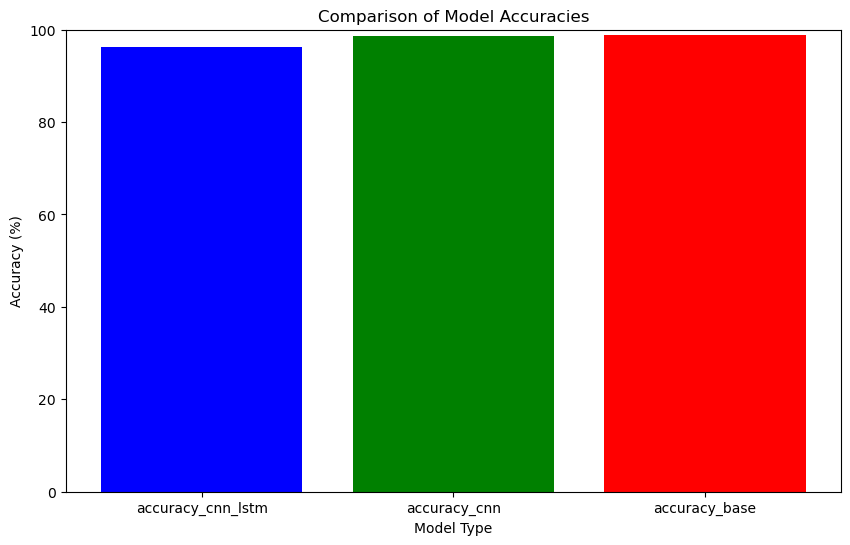

In [27]:
import matplotlib.pyplot as plt

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(accuracy_values.keys(), accuracy_values.values(), color=['blue', 'green', 'red'])

plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100

plt.show()

In [28]:
#alphabets = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','del']

In [29]:
from time import time
cam = cv2.VideoCapture(0)
previous = time()
delta = 0
s = ''

while True:
    # Get the current time, increase delta and update the previous variable
    current = time()
    delta += current - previous
    previous = current
    #t.sleep(30)
    # Check if 3 (or some other value) seconds passed
    if delta > 3:
        # Operations on image
        # Reset the time counter
        delta = 0
        # Show the image and keep streaming
        _, img = cam.read()
        cv2.imshow("Frame", img)
        
        #print(type(cds))
        try:
            cds = coord(img)
            try:
                #print("entering cnn lstm")
                cds_cnn_lstm = eda_cnn_lstm(cds)
                cnn_lstm_prediction = model.predict(cds_cnn_lstm)
                predicted_index_cnn_lstm = np.argmax(cnn_lstm_prediction, axis=1)[0]
                cnn_lstm_flag = 1
                
            except:
                pass
            
            try:
                #print("entering lstm try")
                base_prediction = model_Base.predict(cds)
                predicted_index_base = np.argmax(base_prediction, axis=1)[0]
                base_flag = 1
                
            except:
                pass
            
            try:
                #print("entering cnn try")
                cds_cnn = eda_cnn(cds)
                cnn_prediction = model_cnn.predict(cds_cnn)
                predicted_index_cnn = np.argmax(cnn_prediction, axis=1)[0]
                cnn_flag = 1
            
            except:
                pass
            
            print("The user is communicating: ", alphabets[predicted_index_base])
            
        except TypeError:
            pass
        except:
            pass
    cv2.waitKey(1)

[ WARN:0@180.277] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
2024-05-29 01:08:47.775 python[66969:1472033] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


1/1 [==============================] - 0s 49ms/step
The user is communicating:  A
1/1 [==============================] - 0s 8ms/step
The user is communicating:  A
1/1 [==============================] - 0s 8ms/step
The user is communicating:  A
1/1 [==============================] - 0s 7ms/step
The user is communicating:  O
1/1 [==============================] - 0s 7ms/step
The user is communicating:  O
1/1 [==============================] - 0s 7ms/step
The user is communicating:  O
1/1 [==============================] - 0s 7ms/step
The user is communicating:  C
1/1 [==============================] - 0s 8ms/step
The user is communicating:  L
1/1 [==============================] - 0s 7ms/step
The user is communicating:  L
1/1 [==============================] - 0s 8ms/step
The user is communicating:  M
1/1 [==============================] - 0s 7ms/step
The user is communicating:  M
1/1 [==============================] - 0s 7ms/step
The user is communicating:  N
1/1 [======================

KeyboardInterrupt: 